# PIPELINE XỬ LÝ DỮ LIỆU DẠNG HÌNH ẢNH (Notebook nộp)

**Dữ liệu:** CIFAR-10 – Bộ dữ liệu hình ảnh chuẩn gồm 60.000 ảnh RGB (32×32), chia thành 10 lớp.  
Mục tiêu: Chuẩn hóa và phân tích các bước tiền xử lý trước khi đưa vào mô hình học sâu (CNN).

---

## Cấu trúc notebook

1. **Nạp dữ liệu và giải nén**
   - Đọc và giải nén file `cifar-10-python.tar.gz`
   - Tách ảnh train/test thành thư mục lớp riêng (airplane, cat, ship, ...)

2. **Resize ảnh (Thay đổi kích thước)**
   - Áp dụng 4 thuật toán nội suy: `Nearest`, `Bilinear`, `Bicubic`, `Lanczos`
   - So sánh thời gian xử lý và chất lượng qua chỉ số MSE, PSNR, Entropy

3. **Chuyển thang xám (Grayscale conversion)**
   - Chuyển ảnh RGB sang grayscale bằng công thức chuẩn hóa độ sáng
   - Phân tích phân phối giá trị điểm ảnh và độ sắc nét (Laplacian Variance)

4. **Chuẩn hóa dữ liệu (Normalization / Standardization)**
   - So sánh 3 phương pháp:
     - `[0,1]` scaling  
     - `[-1,1]` scaling  
     - `Z-score` standardization  
   - Đánh giá mean/std và tốc độ hội tụ tiềm năng khi huấn luyện

5. **Phát hiện biên (Edge Detection)**
   - Áp dụng 3 thuật toán: `Sobel`, `Prewitt`, `Canny`
   - Đo mật độ biên (Edge Density) và thời gian xử lý trung bình

6. **Tổng hợp & trực quan hóa**
   - Xuất bảng kết quả so sánh (`.csv`) cho từng nhóm kỹ thuật
   - Vẽ biểu đồ cột, scatter biểu diễn trade-off giữa tốc độ và chi tiết ảnh

---

## Phương án cuối cùng đã chọn (chi tiết trong báo cáo)

- **Resize:** `Bilinear` → cân bằng giữa tốc độ và chất lượng ảnh  
- **Chuẩn hóa:** `Z-score` → mean≈0, std≈1, phù hợp huấn luyện CNN  
- **Phát hiện biên:** `Canny` → biên mảnh, nhiễu thấp, dễ quan sát  
- **Kích thước chuẩn:** `224×224` cho huấn luyện chính thức, `128×128` cho thử nghiệm nhanh  
- **Xuất dữ liệu** 

---

**Tóm lại:**  
Pipeline giúp chuẩn hóa ảnh, tăng độ ổn định và khả năng tái lập,  
đảm bảo dữ liệu đầu vào phù hợp cho các mô hình học sâu hiện đại (ResNet, VGG, DenseNet...).



# Import thư viện

In [28]:
import os
import glob
import time
import tarfile
import pickle
import random
import math

from pathlib import Path
from collections import defaultdict

import numpy as np,cv2
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from sklearn.preprocessing import StandardScaler
from skimage import filters, feature


# CELL 1 — Project paths

In [13]:
proj_root = Path.cwd()
if proj_root.name.lower() == "notebooks":
    proj_root = proj_root.parent
    os.chdir(proj_root)

print("CWD:", Path.cwd())

DATA_DIR   = proj_root / "data"
TAR_PATH   = DATA_DIR / "cifar-10-python.tar.gz"
CIFAR_DIR  = DATA_DIR / "cifar-10-batches-py"
OUT_IMG   = proj_root / "output" / "images"

print("DATA_DIR  :", DATA_DIR)
print("CIFAR_DIR :", CIFAR_DIR)
print("OUT_IMG :", OUT_IMG)

CWD: d:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing
DATA_DIR  : d:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing\data
CIFAR_DIR : d:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing\data\cifar-10-batches-py
OUT_IMG : d:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing\output\images


# CELL 2 — Extract CIFAR-10 tar.gz once

In [14]:
if not CIFAR_DIR.exists():
    assert TAR_PATH.exists(), f"Không thấy {TAR_PATH}"
    with tarfile.open(TAR_PATH, "r:gz") as tar:
        tar.extractall(DATA_DIR)
    print(" Extracted to:", CIFAR_DIR.resolve())
else:
    print(" Already exists:", CIFAR_DIR.resolve())

 Already exists: D:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing\data\cifar-10-batches-py


# CELL 3 — Batch loader & label names

In [15]:
def load_cifar_batch(path: Path):
    path = Path(path)
    with open(path, "rb") as f:
        d = pickle.load(f, encoding="latin1")   # keys: data, labels
    X = d["data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N,32,32,3) RGB
    y = np.array(d["labels"], dtype=np.int64)
    return X, y

meta_path = CIFAR_DIR / "batches.meta"
with open(meta_path, "rb") as f:
    meta = pickle.load(f, encoding="latin1")
LABEL_NAMES = meta["label_names"]
label2name  = {i:n for i,n in enumerate(LABEL_NAMES)}
print("Labels:", LABEL_NAMES)


Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# CELL 4 — Export PNGs into output/images/{train|test}/{class}/...

In [16]:
MODE = "sample"         # "all" hoặc "sample"
N_PER_CLASS = 100       # ảnh/lớp khi MODE="sample"

def export_split(split="train"):
    if split=="train":
        batch_files = [CIFAR_DIR / f"data_batch_{i}" for i in range(1,6)]
    elif split=="test":
        batch_files = [CIFAR_DIR / "test_batch"]
    else:
        raise ValueError("split must be 'train' or 'test'")
    per_class = defaultdict(int); total = 0
    for bf in batch_files:
        X, y = load_cifar_batch(bf)
        for i in range(len(X)):
            cls = int(y[i]); name = label2name[cls]
            if MODE=="sample" and per_class[cls] >= N_PER_CLASS: 
                continue
            cls_dir = OUT_IMG / split / name
            cls_dir.mkdir(parents=True, exist_ok=True)
            out_path = cls_dir / f"{name}_{per_class[cls]:05d}.png"
            Image.fromarray(X[i]).save(out_path)
            per_class[cls] += 1; total += 1
    return total, dict(per_class)

saved_train, stat_train = export_split("train")
saved_test,  stat_test  = export_split("test")
print(f"Exported {saved_train} train, {saved_test} test → {OUT_IMG}")


Exported 1000 train, 1000 test → d:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing\output\images


# CELL 5 — Collect image paths

In [17]:
IMG_DIR = OUT_IMG / "train"          # đổi sang "test" nếu muốn
paths   = glob.glob(str(IMG_DIR / "**" / "*.png"), recursive=True)
assert len(paths)>0, f"Không thấy ảnh trong {IMG_DIR}"
print("📦 Total images:", len(paths))
print("↪️  Example:", paths[0])

📦 Total images: 1000
↪️  Example: d:\IT\HK1_Nam4\Khai thac du lieu va ung dung\01_Image_Preproccessing\output\images\train\airplane\airplane_00000.png


# CELL 6 — Resize utils + metrics

In [18]:
TARGET_SIZES = [(128,128), (224,224)]
PAD_COLOR = (0,0,0)

PIL_INTERP = {
    "nearest": Image.NEAREST,
    "bilinear": Image.BILINEAR,
    "bicubic": Image.BICUBIC,
    "lanczos": Image.LANCZOS,
}

def letterbox_resize(im, size=(224,224), color=(0,0,0), resample=Image.BILINEAR):
    w,h = im.size; sw,sh = size
    scale = min(sw/w, sh/h)
    nw,nh = int(w*scale), int(h*scale)
    imr   = im.resize((nw,nh), resample)
    canvas= Image.new("RGB", size, color)
    canvas.paste(imr, ((sw-nw)//2, (sh-nh)//2))
    return canvas

def mse(a, b):
    a = np.asarray(a, np.float32); b=np.asarray(b, np.float32)
    return float(np.mean((a-b)**2))

def psnr(a, b, maxval=255.0):
    m = mse(a,b)
    return float("inf") if m==0 else 20.0*math.log10(maxval) - 10.0*math.log10(m)

def gray_entropy(img_rgb):
    g = np.asarray(ImageOps.grayscale(img_rgb), dtype=np.uint8)
    hist, _ = np.histogram(g, bins=256, range=(0,255), density=True)
    p = hist + 1e-12
    return float(-(p*np.log2(p)).sum())

# CELL 7 — Interpolation benchmark & quality vs bilinear

In [26]:
# === Benchmark nội suy ảnh (KHÔNG LƯU RA FILE) ===
rows_bench, rows_quality = [], []

for size in TARGET_SIZES:
    # Tạo ảnh tham chiếu dùng Bilinear để so sánh PSNR/MSE
    refs = []
    for p in paths:
        im = Image.open(p).convert("RGB")
        refs.append(letterbox_resize(im, size=size, color=PAD_COLOR, resample=PIL_INTERP["bilinear"]))

    # Chạy qua từng phương pháp nội suy
    for name, interp in PIL_INTERP.items():
        t0 = time.time()
        ent, psnrs, mses = [], [], []

        for i, p in enumerate(paths):
            im = Image.open(p).convert("RGB")
            out = letterbox_resize(im, size=size, color=PAD_COLOR, resample=interp)

            # Tính entropy (độ chi tiết ảnh)
            ent.append(gray_entropy(out))

            # Tính PSNR và MSE so với ảnh bilinear
            if name != "bilinear":
                psnrs.append(psnr(out, refs[i]))
                mses.append(mse(out, refs[i]))

        # Tính thời gian trung bình trên mỗi ảnh
        dt = (time.time() - t0) * 1000.0 / len(paths)

        # Ghi kết quả hiệu năng
        rows_bench.append({
            "size": f"{size[0]}x{size[1]}",
            "method": name,
            "time_ms_per_img": dt,
            "img_per_sec": 1000.0 / dt if dt > 0 else np.nan
        })

        # Ghi kết quả chất lượng ảnh
        rows_quality.append({
            "size": f"{size[0]}x{size[1]}",
            "method": name,
            "entropy_mean": float(np.mean(ent)),
            "psnr_vs_bilinear_mean": float(np.mean(psnrs)) if name != "bilinear" else np.nan,
            "mse_vs_bilinear_mean":  float(np.mean(mses))  if name != "bilinear" else np.nan
        })

# Tạo DataFrame hiển thị
df_interp = (
    pd.DataFrame(rows_bench)
    .sort_values(["size", "method"])
    .reset_index(drop=True)
)

df_iq = (
    pd.DataFrame(rows_quality)
    .sort_values(["size", "method"])
    .reset_index(drop=True)
)

# Hiển thị trực tiếp trong notebook (không lưu file)
try:
    display(df_interp)
    display(df_iq)
except NameError:
    print(df_interp)
    print(df_iq)


,size,method,time_ms_per_img,img_per_sec
0,128x128,bicubic,1.138221,878.563985
1,128x128,bilinear,0.792622,1261.636049
2,128x128,lanczos,1.234293,810.180257
3,128x128,nearest,1.011101,989.020872
4,224x224,bicubic,3.422689,292.167904
5,224x224,bilinear,1.778925,562.137113
6,224x224,lanczos,5.104418,195.908710
7,224x224,nearest,2.914752,343.082333


,size,method,entropy_mean,psnr_vs_bilinear_mean,mse_vs_bilinear_mean
0,128x128,bicubic,7.131263,39.215660,8.998758
1,128x128,bilinear,7.097367,NaN,NaN
2,128x128,lanczos,7.148673,35.633025,20.768785
3,128x128,nearest,6.990580,29.194907,90.524370
4,224x224,bicubic,7.136933,39.421878,8.587792
5,224x224,bilinear,7.105043,NaN,NaN
6,224x224,lanczos,7.154471,35.733564,20.307375
7,224x224,nearest,6.990580,29.027118,94.101561


# CELL 8 — Normalization stats

In [27]:
def norm_01(a):  return a.astype(np.float32) / 255.0
def norm_m11(a): return a.astype(np.float32) / 127.5 - 1.0

# compute dataset mean/std on 224 bilinear
resized = []
for p in paths:
    im = Image.open(p).convert("RGB")
    out = letterbox_resize(im, size=(224, 224), color=PAD_COLOR, resample=PIL_INTERP["bilinear"])
    resized.append(np.asarray(out, np.uint8))

def zscore_stats(arrs):
    s0 = np.zeros(3); s1 = np.zeros(3); n = 0
    for x in arrs:
        xx = x.reshape(-1, 3).astype(np.float64)
        s0 += xx.sum(axis=0)
        s1 += (xx**2).sum(axis=0)
        n  += xx.shape[0]
    mean = s0 / n
    var  = s1 / n - mean**2
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean, std

mean, std = zscore_stats(resized)

rows = []
X01_mean = np.mean([norm_01(x).mean(axis=(0,1)) for x in resized], axis=0)
X01_std  = np.mean([norm_01(x).std(axis=(0,1))  for x in resized], axis=0)
rows.append({
    "variant": "[0,1]",
    "mean_R": X01_mean[0], "mean_G": X01_mean[1], "mean_B": X01_mean[2],
    "std_R":  X01_std[0],  "std_G":  X01_std[1],  "std_B":  X01_std[2],
})

Xm_mean = np.mean([norm_m11(x).mean(axis=(0,1)) for x in resized], axis=0)
Xm_std  = np.mean([norm_m11(x).std(axis=(0,1))  for x in resized], axis=0)
rows.append({
    "variant": "[-1,1]",
    "mean_R": Xm_mean[0], "mean_G": Xm_mean[1], "mean_B": Xm_mean[2],
    "std_R":  Xm_std[0],  "std_G":  Xm_std[1],  "std_B":  Xm_std[2],
})

rows.append({
    "variant": "Z-score(dataset)",
    "mean_R": mean[0], "mean_G": mean[1], "mean_B": mean[2],
    "std_R":  std[0],  "std_G":  std[1],  "std_B":  std[2],
})

df_norm = pd.DataFrame(rows)

# Hiển thị tại chỗ, KHÔNG lưu file
try:
    display(df_norm)
except NameError:
    print(df_norm)


,variant,mean_R,mean_G,mean_B,std_R,std_G,std_B
0,"[0,1]",0.490262,0.482265,0.444056,0.195924,0.192146,0.194367
1,"[-1,1]",-0.019489,-0.035478,-0.111899,0.391849,0.384291,0.388734
2,Z-score(dataset),125.015191,122.976610,113.232630,60.995400,60.328171,65.253604


# CELL 9 — Edge detectors

In [29]:
def _to_u8(gray):
    return gray if gray.dtype == np.uint8 else np.clip(gray, 0, 255).astype(np.uint8)

def edges_sobel(gray_u8):
    g = _to_u8(gray_u8)
    gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(gx, gy)
    mag_u8 = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, mask = cv2.threshold(mag_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def edges_prewitt(gray_u8):
    g = _to_u8(gray_u8)
    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], np.float32)
    ky = np.array([[ 1,1,1],[ 0,0,0],[-1,-1,-1]], np.float32)
    gx = cv2.filter2D(g, cv2.CV_32F, kx)
    gy = cv2.filter2D(g, cv2.CV_32F, ky)
    mag = cv2.magnitude(gx, gy)
    mag_u8 = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, mask = cv2.threshold(mag_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def edges_canny(gray_u8, low=100, high=200):
    return cv2.Canny(_to_u8(gray_u8), low, high)

def edge_density(edge_img):
    return float(np.count_nonzero(edge_img)) / edge_img.size

rows = []
for idx, p in enumerate(paths):
    im = Image.open(p).convert("RGB")
    imr = letterbox_resize(im, size=(224, 224), color=PAD_COLOR, resample=PIL_INTERP["bilinear"])
    gray = np.asarray(ImageOps.grayscale(imr), np.uint8)

    for name, fn in [("Sobel", edges_sobel), ("Prewitt", edges_prewitt), ("Canny", edges_canny)]:
        t0 = time.time()
        e  = fn(gray)
        t1 = time.time()
        rows.append({
            "ID": idx,
            "Image": Path(p).name,
            "method": name,
            "edge density": edge_density(e),
            "time (ms)": (t1 - t0) * 1000.0
        })

df_edges = pd.DataFrame(rows)

# Tính hàng mean theo phương pháp
df_mean = (
    df_edges.groupby("method", as_index=False)[["edge density", "time (ms)"]]
            .mean()
            .assign(ID="<MEAN>", Image="<ALL>")
)[["ID", "Image", "method", "edge density", "time (ms)"]]

# Ghép để hiển thị chung
df_edges_out = pd.concat([df_edges, df_mean], ignore_index=True)

# Hiển thị tại chỗ, KHÔNG ghi CSV
try:
    display(df_mean)        # bản tóm tắt theo method
    # display(df_edges_out) # nếu muốn xem toàn bộ từng ảnh, bỏ comment dòng này
except NameError:
    print(df_mean.head())


,ID,Image,method,edge density,time (ms)
0,<MEAN>,<ALL>,Canny,0.001152,0.281578
1,<MEAN>,<ALL>,Prewitt,0.219135,0.639475
2,<MEAN>,<ALL>,Sobel,0.219227,0.320870


# CELL 10 — 128 vs 224 trade-off table

In [30]:
def bench_size(size):
    ent_list, ed_list, t_list = [], [], []
    for p in paths:
        im = Image.open(p).convert("RGB")
        t0 = time.time()
        imr = letterbox_resize(im, size=size, color=PAD_COLOR, resample=PIL_INTERP["bilinear"])
        gray = np.asarray(ImageOps.grayscale(imr), np.uint8)
        e = edges_sobel(gray)  # dùng Sobel cố định để so sánh
        t1 = time.time()
        ent_list.append(gray_entropy(imr))
        ed_list.append(edge_density(e))
        t_list.append((t1 - t0) * 1000.0)

    # Ước lượng bộ nhớ/ảnh (float32 tensors)
    H, W = size[1], size[0]  # size = (W, H)
    mem_float32 = H * W * 3 * 4 / 1024 / 1024  # MB/ảnh

    return {
        "size": f"{size[0]}x{size[1]}",
        "entropy_mean": float(np.mean(ent_list)),
        "edge_density_mean": float(np.mean(ed_list)),
        "time_ms_per_img": float(np.mean(t_list)),
        "approx_mem_per_img_MB(float32)": round(mem_float32, 3),
    }

cmp_rows = [bench_size((128, 128)), bench_size((224, 224))]
df_res = pd.DataFrame(cmp_rows)

# Chỉ hiển thị, KHÔNG ghi CSV
try:
    display(df_res)
except NameError:
    print(df_res)

,size,entropy_mean,edge_density_mean,time_ms_per_img,approx_mem_per_img_MB(float32)
0,128x128,7.097367,0.220629,0.293523,0.188
1,224x224,7.105043,0.219227,0.642790,0.574


# CELL 11 — Visual examples

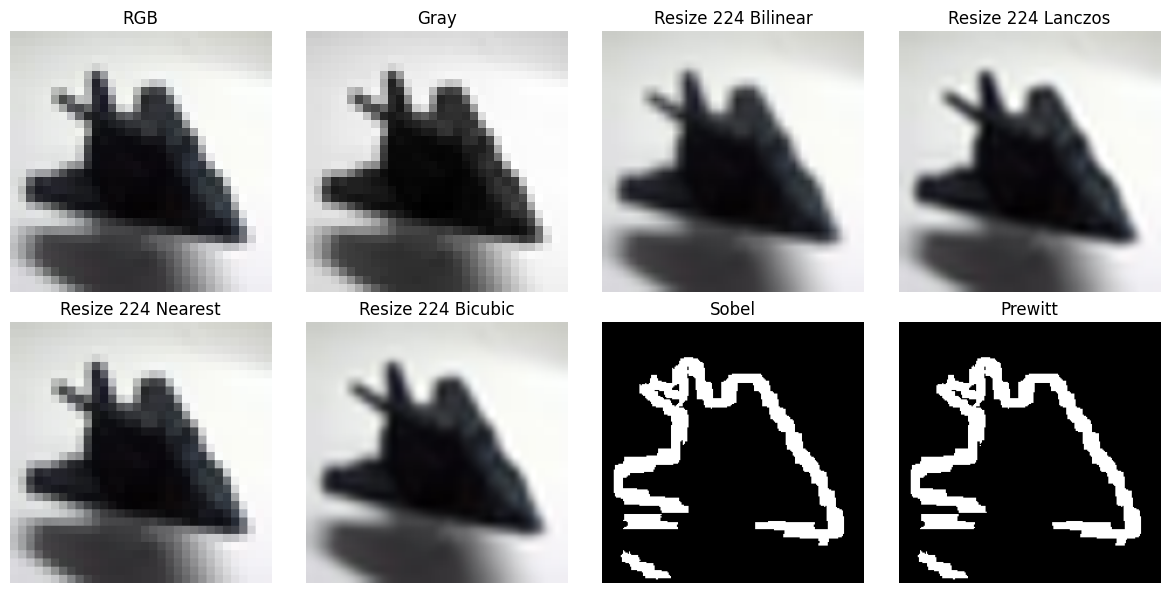

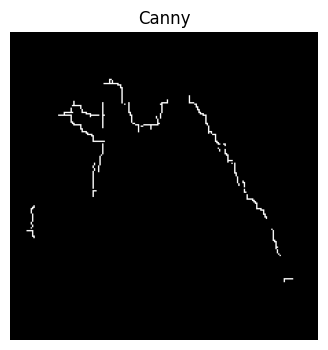

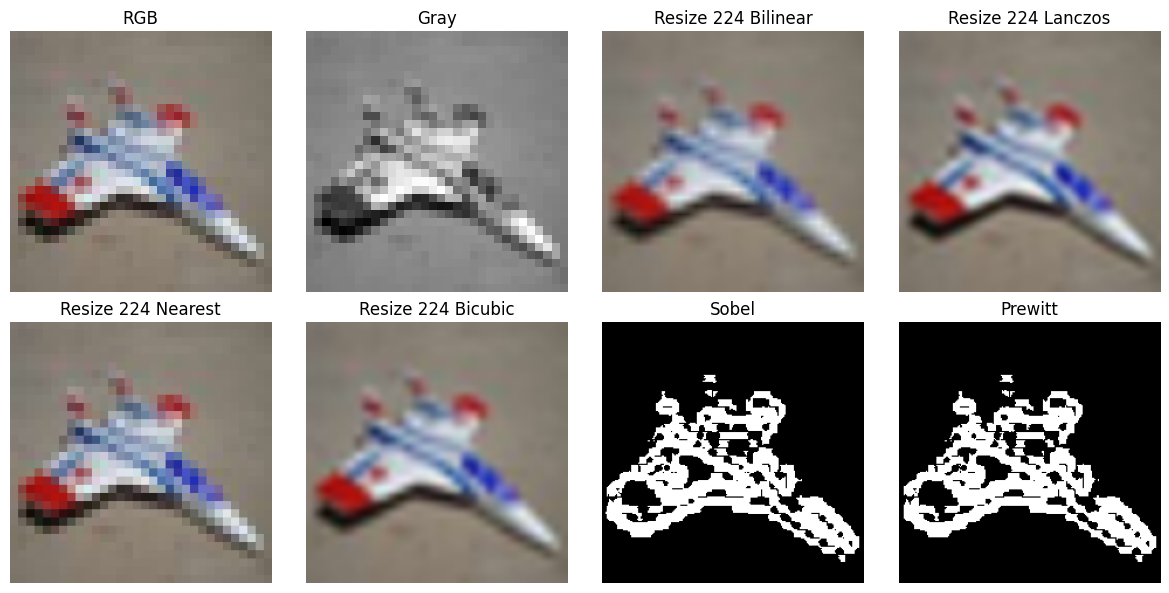

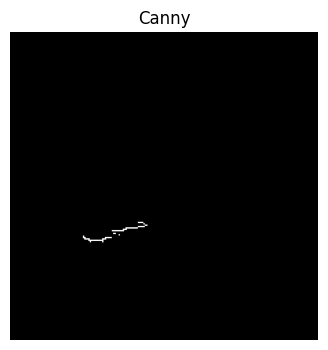

In [ ]:
samples = paths[:2]
for p in samples:
    im = Image.open(p).convert("RGB")
    gray = ImageOps.grayscale(im)
    r224 = {k: letterbox_resize(im, (224,224), PAD_COLOR, v) for k,v in PIL_INTERP.items()}
    g224 = ImageOps.grayscale(r224["bilinear"])
    eS, eP, eC = edges_sobel(np.asarray(g224)), edges_prewitt(np.asarray(g224)), edges_canny(np.asarray(g224))

    fig, ax = plt.subplots(2,4, figsize=(12,6)); ax=ax.ravel()
    ax[0].imshow(im); ax[0].set_title("RGB");  ax[0].axis("off")
    ax[1].imshow(gray, cmap="gray"); ax[1].set_title("Gray"); ax[1].axis("off")
    ax[2].imshow(r224["bilinear"]); ax[2].set_title("Resize 224 Bilinear"); ax[2].axis("off")
    ax[3].imshow(r224["lanczos"]);  ax[3].set_title("Resize 224 Lanczos");  ax[3].axis("off")
    ax[4].imshow(r224["nearest"]);  ax[4].set_title("Resize 224 Nearest");  ax[4].axis("off")
    ax[5].imshow(r224["bicubic"]);  ax[5].set_title("Resize 224 Bicubic");  ax[5].axis("off")
    ax[6].imshow(eS, cmap="gray");  ax[6].set_title("Sobel");   ax[6].axis("off")
    ax[7].imshow(eP, cmap="gray");  ax[7].set_title("Prewitt"); ax[7].axis("off")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4)); plt.imshow(eC, cmap="gray"); plt.title("Canny"); plt.axis("off"); plt.show()


# CELL 12 — Plot setup

In [ ]:
# --- Visualization config (no save directory) ---
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.35

print("Visualization mode: Figures will be displayed only.")

✅ Visualization mode: Figures will be displayed only (not saved).


# CELL 13 — Interpolation plots (speed + quality)

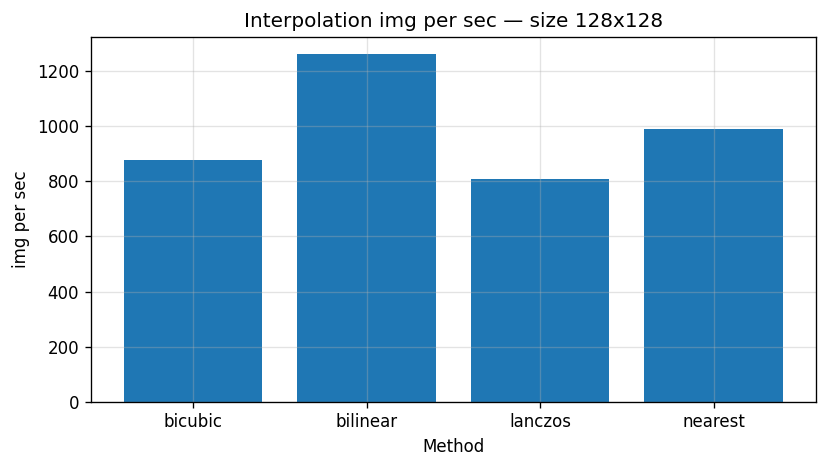

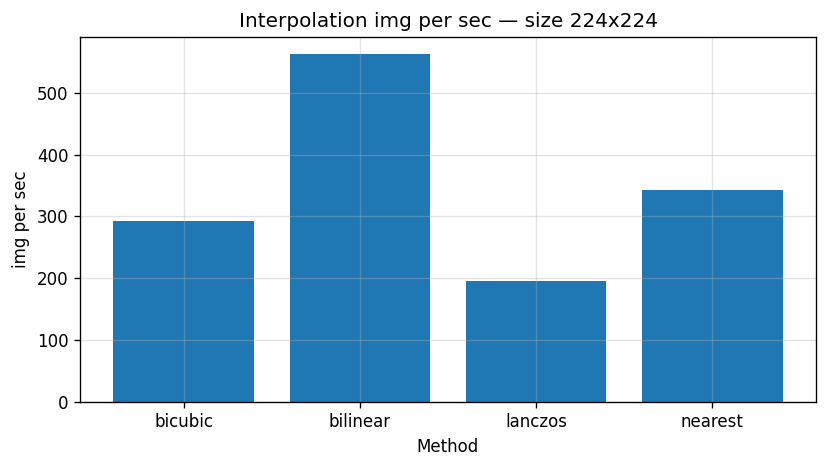

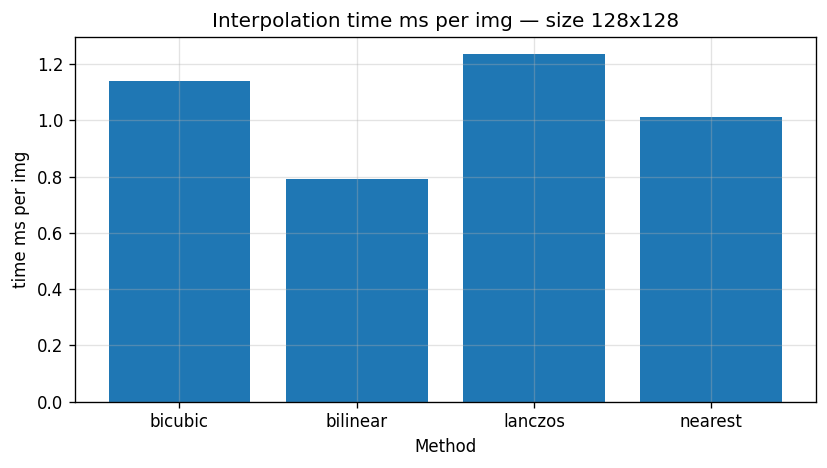

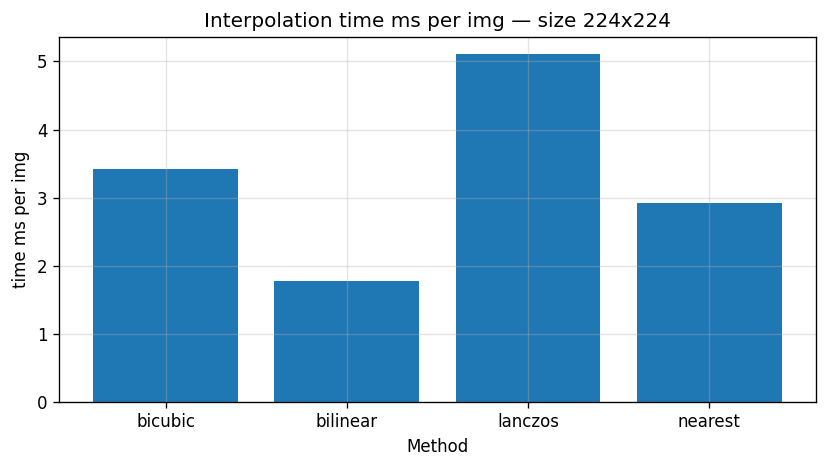

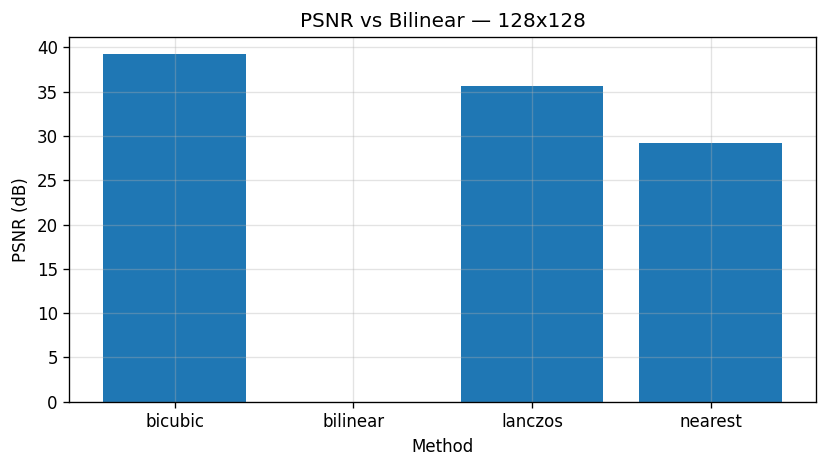

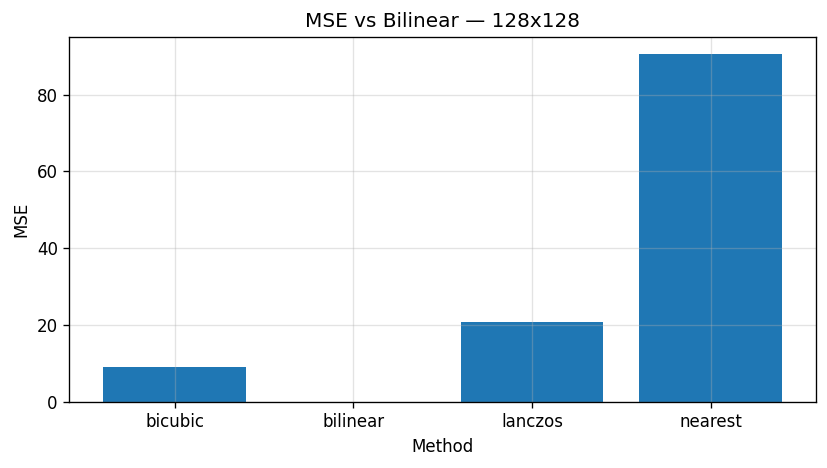

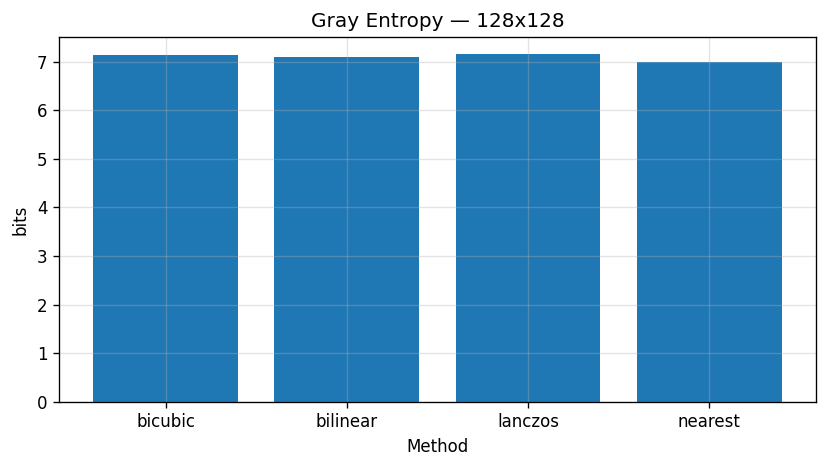

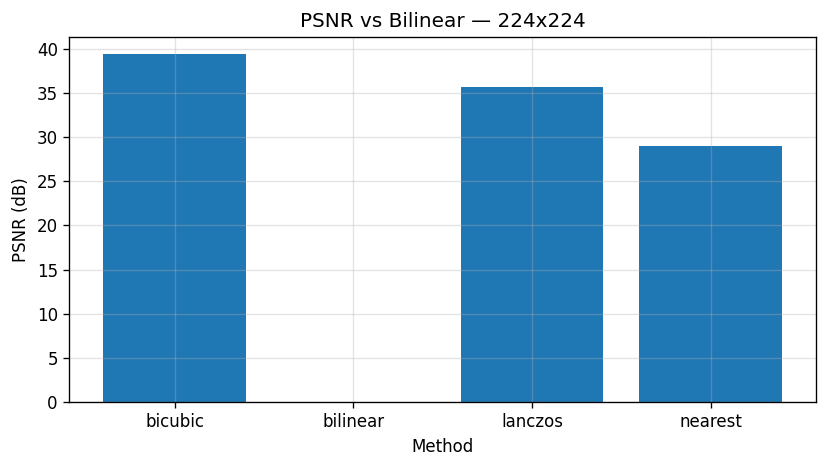

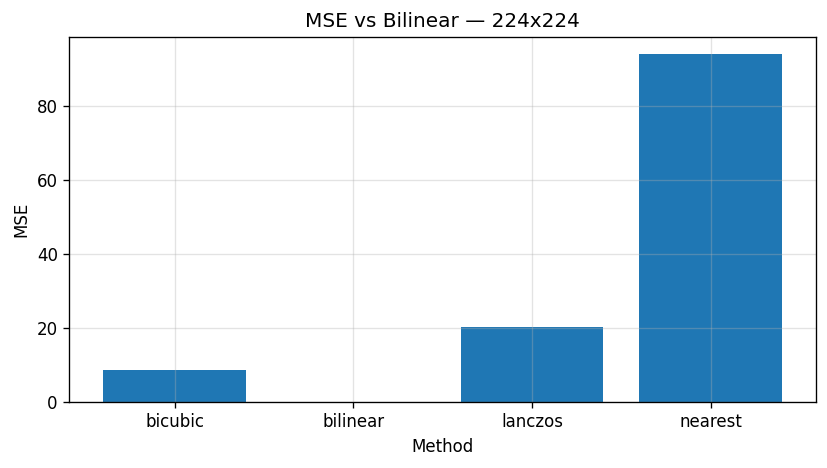

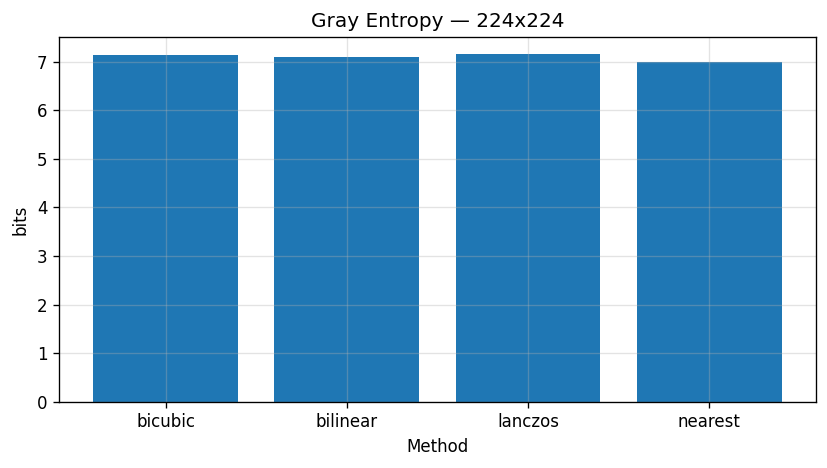

In [35]:
df_bench = df_interp
df_qual  = df_iq

# Biểu đồ tốc độ (images/sec, time/ms) cho từng phương pháp
for metric in ["img_per_sec", "time_ms_per_img"]:
    for sz in sorted(df_bench["size"].unique()):
        d = df_bench[df_bench["size"] == sz]
        plt.figure(figsize=(7, 4))
        plt.bar(d["method"], d[metric])
        plt.title(f"Interpolation {metric.replace('_',' ')} — size {sz}")
        plt.xlabel("Method")
        plt.ylabel(metric.replace('_',' '))
        plt.tight_layout()
        plt.show()

# Biểu đồ chất lượng: PSNR, MSE, Entropy
for sz in sorted(df_qual["size"].unique()):
    d = df_qual[df_qual["size"] == sz].copy()

    # PSNR (bỏ bilinear = NaN)
    plt.figure(figsize=(7, 4))
    plt.bar(d["method"], d["psnr_vs_bilinear_mean"])
    plt.title(f"PSNR vs Bilinear — {sz}")
    plt.ylabel("PSNR (dB)")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()

    # MSE
    plt.figure(figsize=(7, 4))
    plt.bar(d["method"], d["mse_vs_bilinear_mean"])
    plt.title(f"MSE vs Bilinear — {sz}")
    plt.ylabel("MSE")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()

    # Entropy
    plt.figure(figsize=(7, 4))
    plt.bar(d["method"], d["entropy_mean"])
    plt.title(f"Gray Entropy — {sz}")
    plt.ylabel("bits")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()


# CELL 14 — Normalization plots

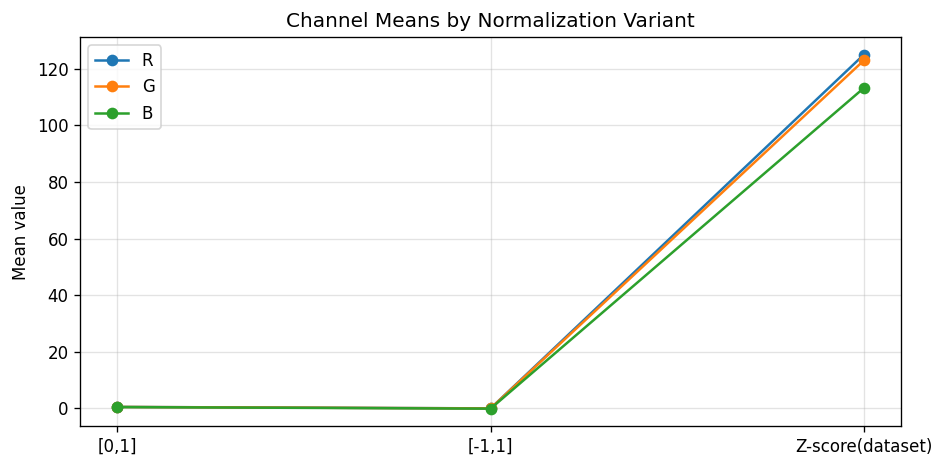

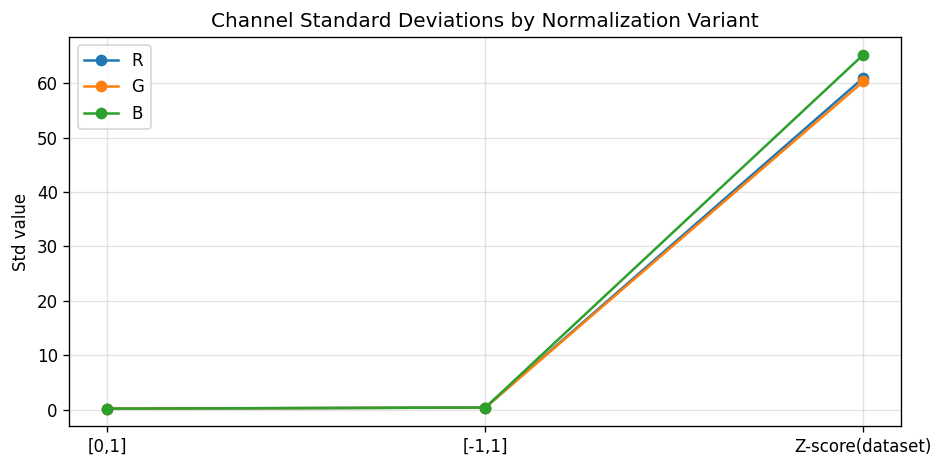

In [37]:
dfn = df_norm  # dùng trực tiếp biến có sẵn

# Mean per channel
plt.figure(figsize=(8,4))
x = range(len(dfn["variant"]))
plt.plot(x, dfn["mean_R"], marker="o", label="R")
plt.plot(x, dfn["mean_G"], marker="o", label="G")
plt.plot(x, dfn["mean_B"], marker="o", label="B")
plt.xticks(x, dfn["variant"])
plt.title("Channel Means by Normalization Variant")
plt.ylabel("Mean value")
plt.legend()
plt.tight_layout()
plt.show()

# Std per channel
plt.figure(figsize=(8,4))
plt.plot(x, dfn["std_R"], marker="o", label="R")
plt.plot(x, dfn["std_G"], marker="o", label="G")
plt.plot(x, dfn["std_B"], marker="o", label="B")
plt.xticks(x, dfn["variant"])
plt.title("Channel Standard Deviations by Normalization Variant")
plt.ylabel("Std value")
plt.legend()
plt.tight_layout()
plt.show()


# CELL 15 — Edge detector plots (use <MEAN> rows)

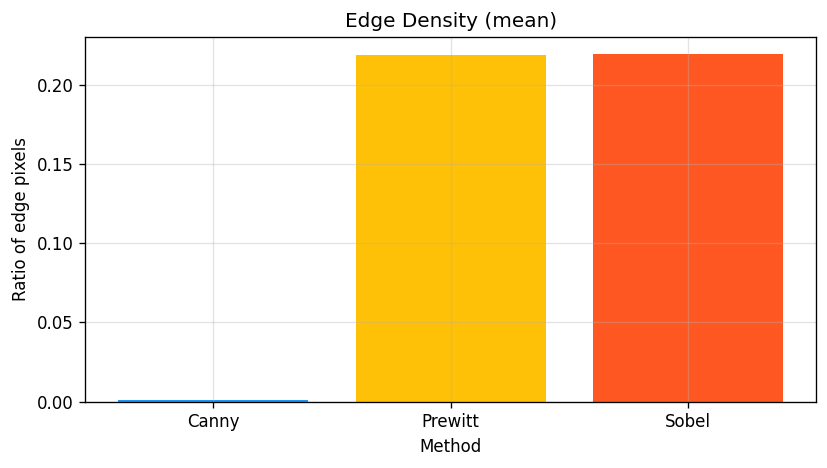

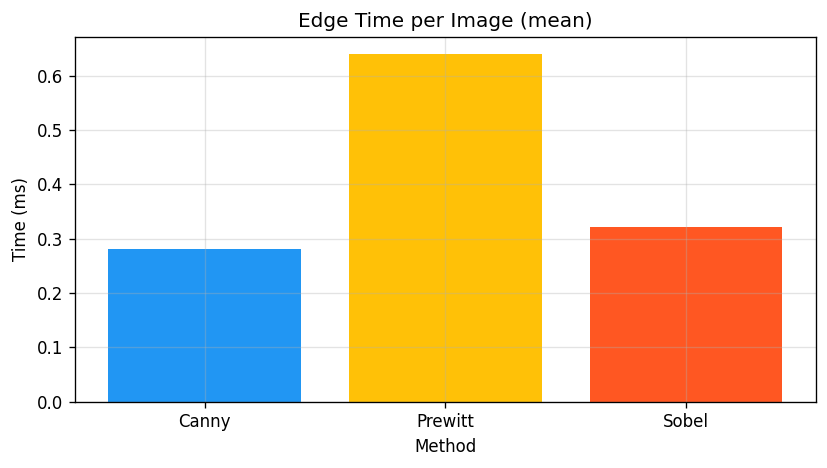

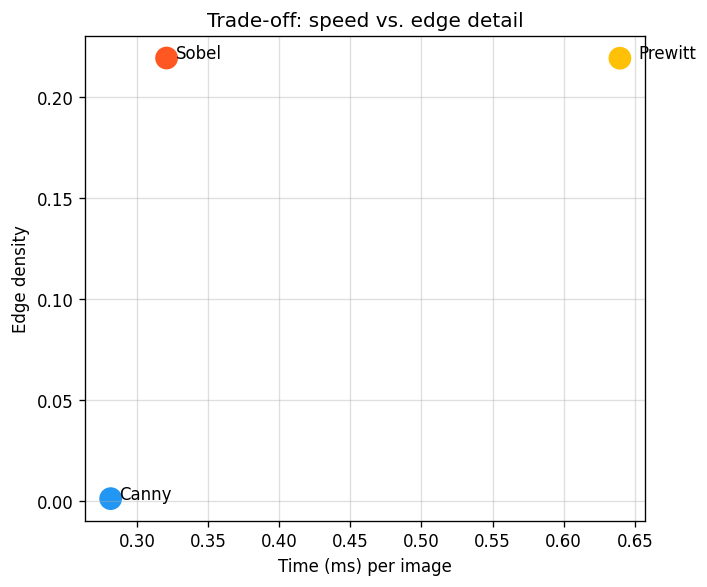

In [38]:
dfe_all = df_edges_out  # dùng trực tiếp DataFrame đã có

# Lấy dòng <MEAN>
dfe = dfe_all[dfe_all["ID"] == "<MEAN>"].copy()

# Bar: Edge Density
plt.figure(figsize=(7,4))
plt.bar(dfe["method"], dfe["edge density"], color=["#2196F3","#FFC107","#FF5722"])
plt.title("Edge Density (mean)")
plt.ylabel("Ratio of edge pixels")
plt.xlabel("Method")
plt.tight_layout()
plt.show()

# Bar: Time per Image
plt.figure(figsize=(7,4))
plt.bar(dfe["method"], dfe["time (ms)"], color=["#2196F3","#FFC107","#FF5722"])
plt.title("Edge Time per Image (mean)")
plt.ylabel("Time (ms)")
plt.xlabel("Method")
plt.tight_layout()
plt.show()

# Scatter: Speed vs Detail
plt.figure(figsize=(6,5))
plt.scatter(dfe["time (ms)"], dfe["edge density"], s=160, c=["#2196F3","#FFC107","#FF5722"])
for _, r in dfe.iterrows():
    plt.text(r["time (ms)"]*1.02, r["edge density"], r["method"], fontsize=10)
plt.xlabel("Time (ms) per image")
plt.ylabel("Edge density")
plt.title("Trade-off: speed vs. edge detail")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


# CELL 16 — Resolution trade-off plots

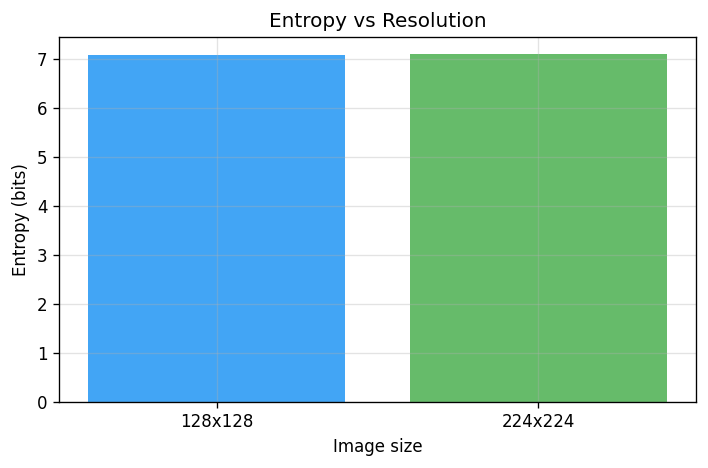

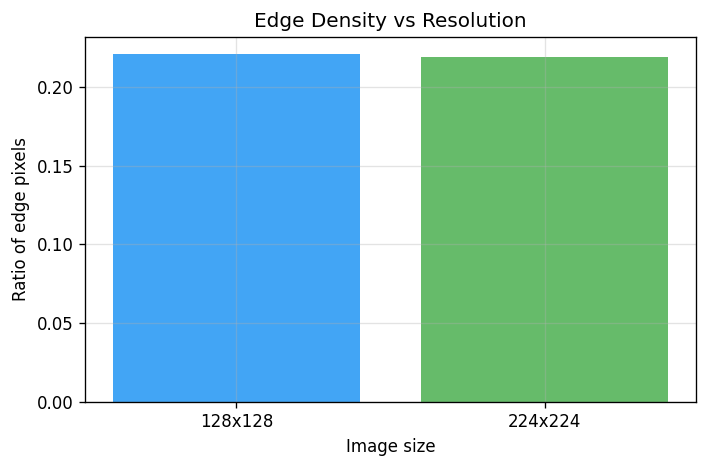

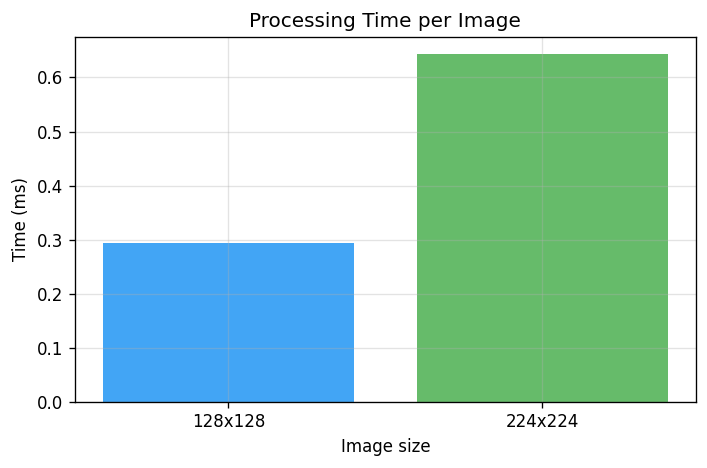

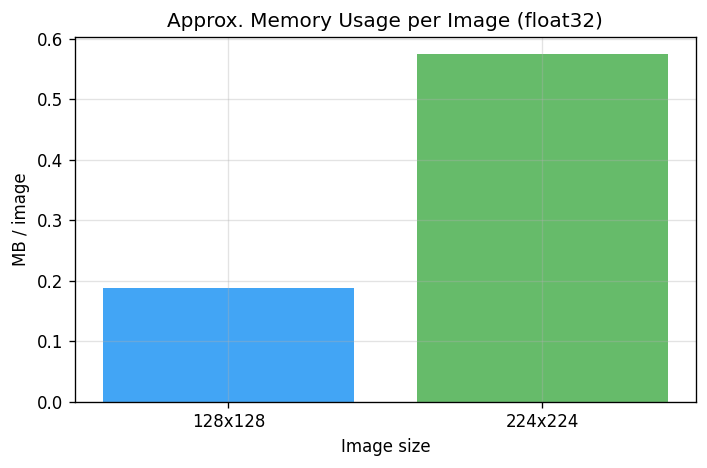

In [39]:
dfr = df_res  # dùng trực tiếp biến từ notebook

# Entropy vs Resolution
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["entropy_mean"], color=["#42A5F5", "#66BB6A"])
plt.title("Entropy vs Resolution")
plt.ylabel("Entropy (bits)")
plt.xlabel("Image size")
plt.tight_layout()
plt.show()

# Edge Density vs Resolution
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["edge_density_mean"], color=["#42A5F5", "#66BB6A"])
plt.title("Edge Density vs Resolution")
plt.ylabel("Ratio of edge pixels")
plt.xlabel("Image size")
plt.tight_layout()
plt.show()

# Time per Image vs Resolution
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["time_ms_per_img"], color=["#42A5F5", "#66BB6A"])
plt.title("Processing Time per Image")
plt.ylabel("Time (ms)")
plt.xlabel("Image size")
plt.tight_layout()
plt.show()

# Approx. Memory per Image (float32)
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["approx_mem_per_img_MB(float32)"], color=["#42A5F5", "#66BB6A"])
plt.title("Approx. Memory Usage per Image (float32)")
plt.ylabel("MB / image")
plt.xlabel("Image size")
plt.tight_layout()
plt.show()